In [7]:
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 

import numpyro 
from numpyro.diagnostics import hpdi 
import numpyro.distributions as dist 
from numpyro import handlers 
from numpyro.infer import MCMC, NUTS 

plt.style.use("bmh")

print(f"Using numpyro version {numpyro.__version__}")

Using numpyro version 0.4.1


In [8]:
DATASET_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv"
df = pd.read_csv(DATASET_URL, sep=';')
df.head(5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


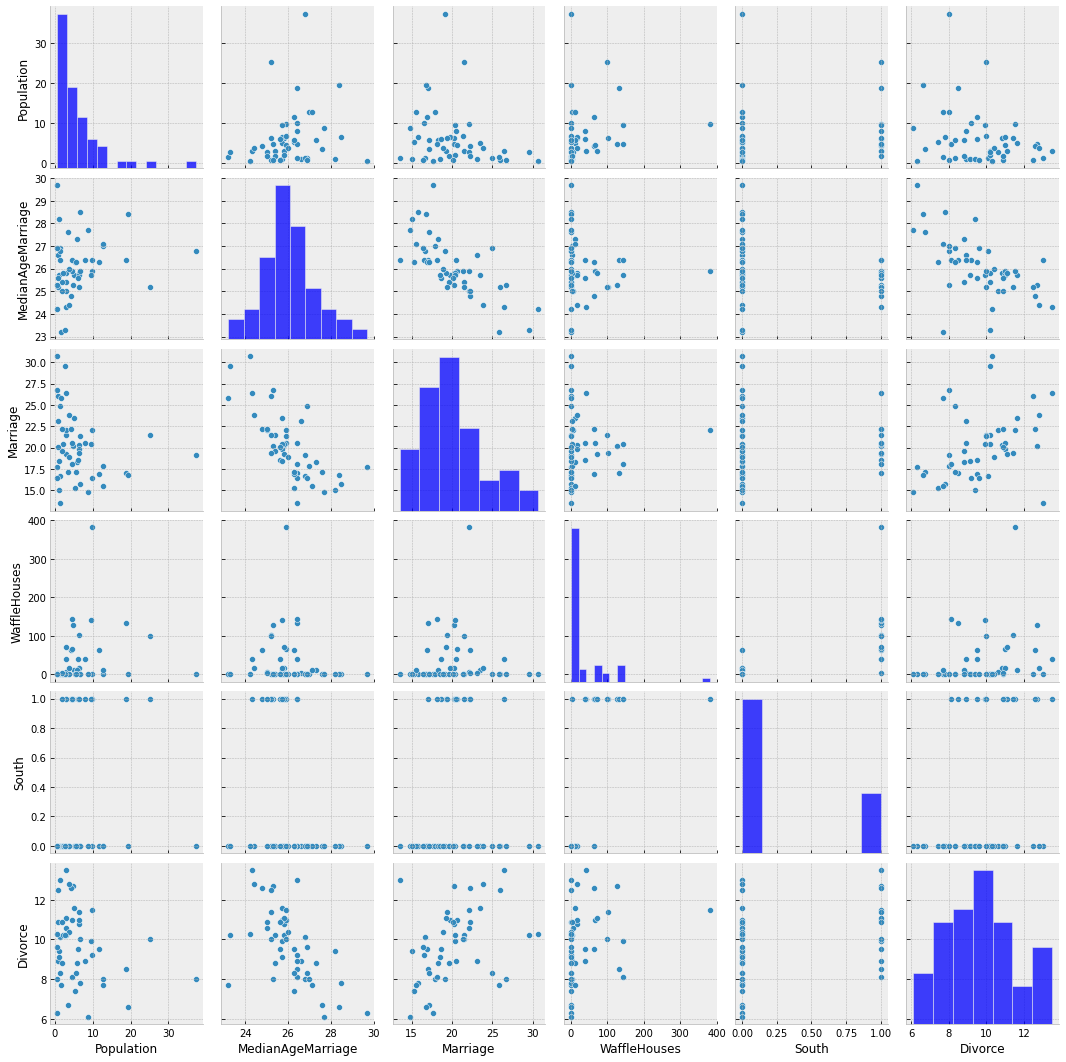

In [12]:
vars = ["Population", "MedianAgeMarriage", "Marriage", "WaffleHouses", "South", "Divorce"]
sns.pairplot(df, x_vars=vars, y_vars=vars, palette="husl")
plt.show()

<AxesSubplot:xlabel='WaffleHouses', ylabel='Divorce'>

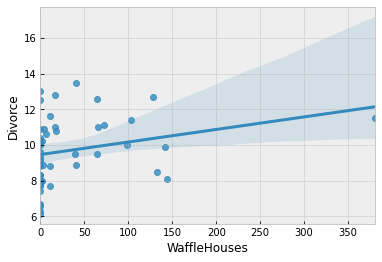

In [13]:
sns.regplot("WaffleHouses", "Divorce", df)

In [15]:
standardize = lambda x: (x-x.mean())/ x.std()

df["AgeScaled"] = df.MedianAgeMarriage.pipe(standardize)
df["MarriageScaled"] = df.Marriage.pipe(standardize)
df["DivorceScaled"] = df.Divorce.pipe(standardize)

A model is any Python callable which caan aaccept additional arguments and keywords. It must also contain primitives like `sample` and additional effect handlers. `sample` makes it a stochastic function which samples from a prior distribution. Ultimately we want to infer the posterior distribution given observed data.



In [19]:
def model(marriage=None, age=None, divorce=None):
    """
        keywords are optional so we can re-use this, to sample from posterior pred distribution

        We can also pass in only certain variables
    
    """
    a = numpyro.sample(name="a", fn=dist.Normal(0., 0.2)) # return a random sample from stochastic function fn

    M, A = 0., 0.

    if marriage is not None:
        bM = numpyro.sample("bM", dist.Normal(0.,0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample('bA', dist.Normal(0.,0.5))
        A = bA * age

    sigma = numpyro.sample("sigma", dist.Exponential(1.))

    mu = a + M + A # lin comb 
    numpyro.sample("obs", dist.Normal(mu,sigma), obs=divorce) # data likelihood


There is a `numpyro.MCMC` convenience class which allows us easy access to MCMC inference algorithms.

In [22]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000

# run NUTS sampling
# tell it which model to use (function we wrote)
kernel = NUTS(model=model)
mcmc = MCMC(sampler=kernel, num_warmup=num_warmup, num_samples=num_samples)

mcmc.run(rng_key_, marriage=df["MarriageScaled"].values, divorce=df["DivorceScaled"].values)

mcmc.print_summary()

samples_1 = mcmc.get_samples()

sample: 100%|██████████| 3000/3000 [00:17<00:00, 173.12it/s, 3 steps of size 7.72e-01. acc. prob=0.91]

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.00      0.11     -0.00     -0.18      0.18   2067.84      1.00
        bM      0.35      0.13      0.35      0.13      0.55   1486.78      1.00
     sigma      0.94      0.10      0.93      0.79      1.10   2151.73      1.00

Number of divergences: 0


In [25]:
samples_1["a"].shape

(2000,)

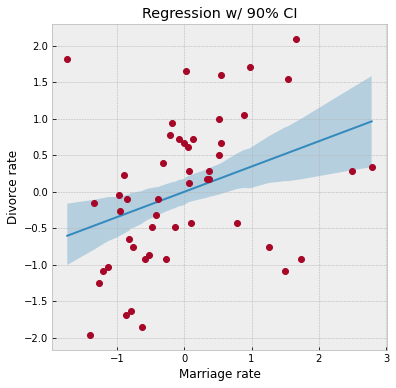

In [34]:
def plot_regression(x,y_mean,y_hpdi):
    # sort values
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:,idx]
    divorce = df["DivorceScaled"].values[idx]

    # plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, 'o')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax


# compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(samples_1['a'], -1) + \
    jnp.expand_dims(samples_1['bM'], -1) * df["MarriageScaled"].values 

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(df["MarriageScaled"].values, mean_mu, hpdi_mu)
ax.set(xlabel="Marriage rate", ylabel="Divorce rate", title="Regression w/ 90% CI")
plt.show()

Use `numpyro.infer.Predictive` to sample from the posterior predictive distribution.

In [35]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=df["MarriageScaled"].values)["obs"]
df2 = df.filter(["Location"])
df2["Mean Predictions"] = jnp.mean(predictions, axis=0)
df2.head()

,Location,Mean Predictions
0,Alabama,0.003534
1,Alaska,0.553430
2,Arizona,0.011047
3,Arkansas,0.537485
4,California,-0.077829


In [37]:
predictions.shape

(2000, 50)